In [2]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

#### Q1. Downloading the data

We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".

Download the data for January and February 2023.

Read the data for January. How many columns are there?

In [4]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

--2024-07-13 08:36:04--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.203.173, 3.160.203.53, 3.160.203.81, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.203.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet’

yellow_tripdata_202 100%[===================>]  45.46M  18.9MB/s    in 2.4s    

2024-07-13 08:36:07 (18.9 MB/s) - ‘yellow_tripdata_2023-01.parquet’ saved [47673370/47673370]

--2024-07-13 08:36:07--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.203.81, 3.160.203.184, 3.160.203.53, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.203.81|:443... connected.
H

In [5]:
!mv yellow_tripdata_* data/

In [4]:
df = pd.read_parquet("data/yellow_tripdata_2023-01.parquet")

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [14]:
len(df.columns)

19

#### Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the standard deviation of the trips duration in January?

In [6]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
df.duration.describe()['std']

42.594351241920904

#### Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

In [8]:
filtered_df = df[(df.duration >= 1) & (df.duration <= 60)]

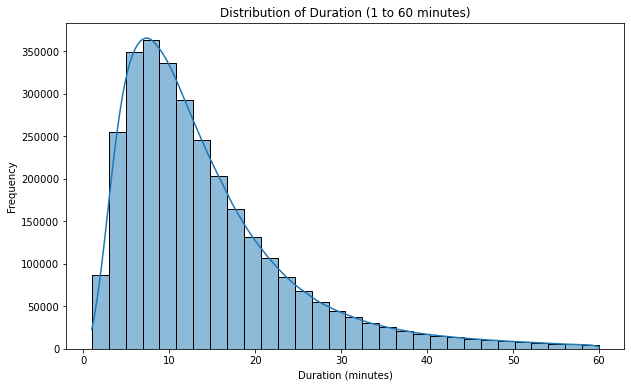

In [18]:
# Check the distribution of the filtered duration variable
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['duration'], bins=30, kde=True)
plt.title('Distribution of Duration (1 to 60 minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Number of records after filtering
filtered_records = len(filtered_df)
total_records = len(df)
# Fraction of records left after filtering
fraction_left = filtered_records / total_records

print(f"Total records before filtering: {total_records}")
print(f"Total records after filtering: {filtered_records}")
print(f"Fraction of records left after filtering: {fraction_left:.2f}")

Total records before filtering: 3066766
Total records after filtering: 3009173
Fraction of records left after filtering: 0.98


#### Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

- Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings, otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

In [9]:
df = filtered_df
categorical = ['PULocationID', 'DOLocationID']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)


In [11]:
len(dv.feature_names_)

515

#### Q5. Training a model
Now let's use the feature matrix from the previous step to train a model.

- Train a plain linear regression model with default parameters, where duration is the response variable
- Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [12]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mse  = mean_squared_error(y_train, y_pred, squared=False)
rmse = np.sqrt(mse)

print(rmse)

2.7657297459993737


#### Q6. Evaluating the model
Now let's apply this model to the validation dataset (February 2023).

What's the RMSE on validation?

In [13]:
def read_dataframe(filename):
 
    df = pd.read_parquet(filename)

    df['duration'] =  df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [14]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [15]:
categorical = ['PULocationID', 'DOLocationID']
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)


7.81183265470218